# Can NLP be leveraged to increase the accuracy of Crypto value forecasting? Probably not, or you wouldn't be reading this. But let's try it anyway. 
This notebook relies on data that I collected from Twitter and financialmodelingprep.com over the course of about a year with a small app, which consisted of some lambda functions which ran on the hour to collect crypto and market index values in real-time. These were then formatted and written to a MySQL database behind the same VPC as the Lambdas. This VPC was secured behind a bastion instance with no local keys, making the entire project very secure. Down the road, I supplemented this with Kaggle's tweet dataset, as well as some more historical crypto data from https://www.cryptodatadownload.com/. These supplemental datasets were open source at the time of access.

In [4]:
import numpy as np
from pathlib import Path
import pandas as pd
from time import time
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import ccf, adfuller
from importlib import reload
from time import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from string import punctuation
from bs4 import BeautifulSoup
import multiprocessing as mp
import re

data_folder = Path('./../../data/')

## (I) Load Data (Crypto / Tweets/ Market)
### Some coins other than BTC and ETH are included. Future experimentation could involve using a large number of coins and performing separate feature extraction on that dataset.

In [5]:
coin_names = ['BTC', 'ETH', 'SOL', 'LINK', 'USDC']
dct_coin_tables = {}
for suffix in coin_names:
    dct_coin_tables[suffix] = pd.read_csv(Path(data_folder / 'coin_index_vals_merged_{}.csv'.format(suffix)), parse_dates=['date'])

print(dct_coin_tables.keys())

df_bitcoin = dct_coin_tables['BTC'] # A view to a table for inspection because VScode Jupyter dict inspection is a catastrophe.
print(df_bitcoin.columns)


dict_keys(['BTC', 'ETH', 'SOL', 'LINK', 'USDC'])
Index(['unix', 'date', 'day_of_week', 'symbol', 'open', 'high', 'low', 'close',
       'Volume USD', 'Volume BTC', 'close_ETH', 'close_SOL', 'close_UST',
       'open_SP500', 'high_SP500', 'low_SP500', 'close_SP500', 'volume_SP500',
       'open_NSDQ_x', 'high_NSDQ_x', 'low_NSDQ_x', 'close_NSDQ_x',
       'volume_NSDQ_x', 'open_NSDQ_y', 'high_NSDQ_y', 'low_NSDQ_y',
       'close_NSDQ_y', 'volume_NSDQ_y'],
      dtype='object')


### Let's take a quick look at Bitcoin (BTC), and see if there is any lagged correlation with other crypto coins.
As everyone knows, cryptocurrency is very volatile. However, this is precisely why leveraging NLP is of interest, since it's possible that some of that volatility is caused by social media, and the shared attitudes of crypto enthusiasts/investors.

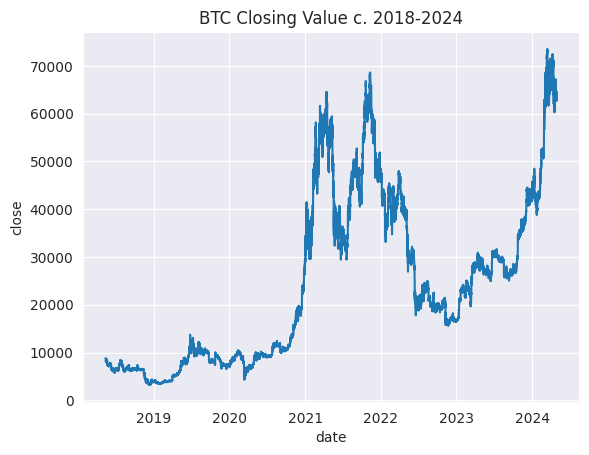

In [6]:
# Let's take a look at BTC before considering CCF with other coins.
ax = sns.lineplot(data=df_bitcoin, x='date', y='close')
ax.set_title('BTC Closing Value c. 2018-2024')
plt.show()

### Let's take a look at the stationarity of the time series.

In [10]:
btc_close = dct_coin_tables['BTC']['close'].to_numpy()
ether_close = dct_coin_tables['ETH']['close'].to_numpy()
btc_close_diff = np.diff(btc_close)
ether_close_diff = np.diff(ether_close)

# Ether starts later than BTC.
eth_start = dct_coin_tables['ETH']['date'].min()
mask_for_btc = dct_coin_tables['BTC']['date'] >= eth_start
btc_close = btc_close[mask_for_btc]

print('ADF Test Results:\nBTC: {} ---- df BTC: {}\nEther: {} ---- df ETHER: {}'.format(adfuller(btc_close), adfuller(btc_close_diff), adfuller(ether_close), adfuller(ether_close_diff)))
# test_corr = ccf(btc_close, ether_close)

ADF Test Results:
BTC: (-0.5592064050819889, 0.8799358932978059, 58, 52126, {'1%': -3.430475457968319, '5%': -2.861595449895273, '10%': -2.5667995141366813}, 708538.0541992125) ---- df BTC: (-29.533756506479985, 0.0, 58, 52125, {'1%': -3.4304754603753054, '5%': -2.86159545095909, '10%': -2.56679951470292}, 708521.2504354062)
Ether: (-1.132333527099498, 0.7020069838427792, 58, 52118, {'1%': -3.430475477226794, '5%': -2.861595458406951, '10%': -2.566799518667196}, 436275.5556912424) ---- df ETHER: (-29.16435050465613, 0.0, 57, 52118, {'1%': -3.430475477226794, '5%': -2.861595458406951, '10%': -2.566799518667196}, 436267.2447307998)


### The results suggest BTC and ETH are weakly non-stationary, so for the purposes of correlation, we'll use backward difference, which is strongly non-stationary.

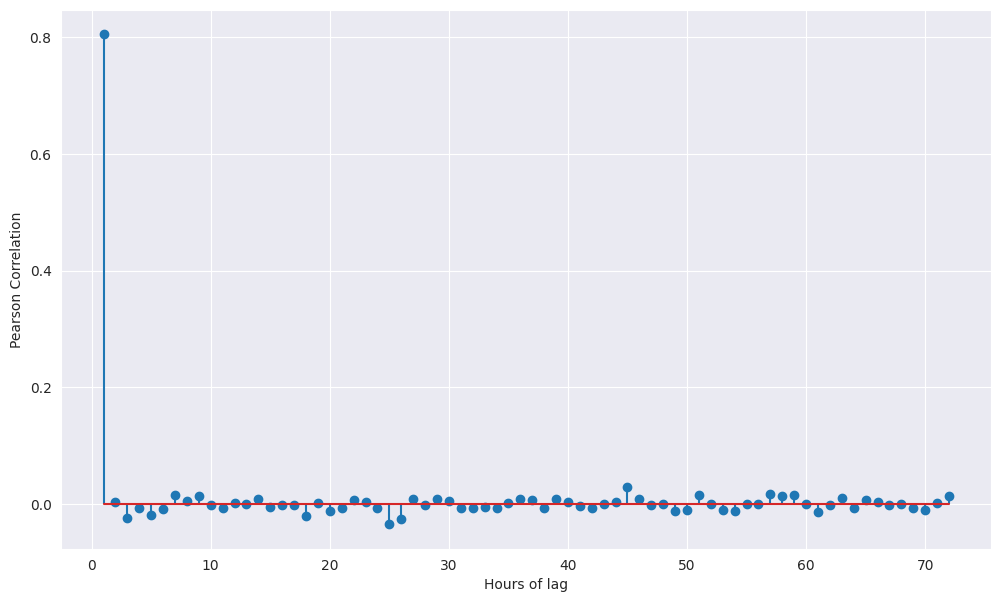

In [7]:
# Need to line up the BTC/ETH datasets first, they don't have precisely the same date records. Ether winds up having a few NULL values, but trivially small in number, so we'll just forward fill.
df_btc_eth = df_bitcoin[['date', 'close']].merge(dct_coin_tables['ETH'][['date', 'close']], how='left', on='date', suffixes=['_btc', '_eth'])
df_btc_eth['close_eth'] = df_btc_eth['close_eth'].ffill()
btc_close_diff = np.diff(df_btc_eth['close_btc'].to_numpy())
eth_close_diff = np.diff(df_btc_eth['close_eth'].to_numpy())

# I want to look at lag intervals of one hour, i.e. each row of the crypto datasets, so luckily there's no need to do anything special. Let's look at a lag of up to 72 hours.
lag_vals = 72
conf_interv = 0.05
lagged_corr, lag_conf_intervals = ccf(btc_close_diff, eth_close_diff, nlags=lag_vals, alpha=conf_interv, adjusted=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
x = range(1, lag_vals + 1, 1)
plt.stem(x, lagged_corr, label='Lagged Cross-Correlation between BTC and ETH')
ax.set_xlabel('Hours of lag')
ax.set_ylabel('Pearson Correlation')
plt.show()

This is rather interesting. It would appear that Ether has a powerful, lagged correlation to BTC at one hour that then disappears almost immediately.

### Now that we've taken a look at the crypto data, let's load the tweet dataset and proceed with feature extraction. The tweet data includes raw tweets, as well as sentiment data from an up-to-date roBERTa model. We also filter the bitcoin data to conform to the tweet data's date-range.

In [5]:
tweet_sent_path = Path(data_folder / 'tweets_and_sent.pickle')

df_tweets = pd.read_pickle(tweet_sent_path)
print("Tweet and sentiment shape: {}".format(df_tweets.shape))

# Filter bitcoin data to match the date-range of the tweet data.
assert(df_bitcoin['date'].dtype == df_tweets['date'].dtype)
date_start = df_tweets['date'].min()
date_end = df_tweets['date'].max()

# Note the date mask needs to be kept around for some models and not others. In some cases, e.g. TFT, I believe the
# tweet data can be nan-filled and used with the full crypto dataset. In others, e.g. ARIMA, I believe all multivariate
# features need to be present.
mask_dates = (df_bitcoin['date'] >= date_start) & (df_bitcoin['date'] <= date_end)
mask_dates = mask_dates.to_numpy()
# mask_dates = np.where(mask_dates.to_numpy())[0]
print(np.sum(mask_dates))
# This is a view, be mindful of indices.
df_bitcoin_post_tweets = df_bitcoin[mask_dates]

Tweet and sentiment shape: (5261255, 10)


# (II) Feature Extraction
### The sentiment has already been processed, but I also want to directly use tokenized tweets as features in some way. To accomplish this, I need to do some cleaning that wasn't necessary for sentiment analysis. Standard stuff: stop words, punctuation, URLs, HTLM tags, Lemmatization.

In [ ]:
# A pipeline is created to use precisely the same resources as the sentiment extraction. Stop words and punctuation are removed,
# html tags stripped, URLs are stripped, and then the text is lemmatized and concatenated back into a 'sentence' for token 
# extraction.

path_clean_tweet_tokens = Path(data_folder / 'clean_tweet_tokens.pickle')
overwrite = False
if overwrite or not path_clean_tweet_tokens.exists():
    from transformers import pipeline
    sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=0)

    # Any weird words I want to include.
    additional_words = []

    remove_words = set(stopwords.words('english') + list(punctuation) + additional_words)
    cleaned_tweets = []


    def clean_tweet(text):
        # First do pre-split cleaning
        text = text.lower()
        text = BeautifulSoup(text, 'lxml').text

        # Any regex matches you want to drop. Opening HTML strikethroughs were leaking through for example.
        # Explanation of regexes: [remove <xxx> up to 3 letters enclosed, remove URLs,  ]
        regex_list = ['<[^>]+>', r'http\S+']
        for regex in regex_list:
            text = re.sub(regex, '', text)

        # Tokenized cleaning
        text_split = word_tokenize(text)
        stopwords_removed = [word for word in text_split if word not in remove_words]
        lemmatizer = WordNetLemmatizer()
        cleaned_text = [lemmatizer.lemmatize(word) for word in stopwords_removed]

        return " ".join(cleaned_text)

    all_tweets = df_tweets['text'].to_list()

    # This is cpu bound.
    start = time()
    num_cores = mp.cpu_count() - 2
    with mp.Pool(processes=num_cores) as pool:
        cleaned_tweets = list(pool.map(clean_tweet, all_tweets))
    end = time()
    print("Time taken to clean tweets: {}".format(end - start))

    tweet_tokens = sentiment_pipeline.tokenizer(cleaned_tweets, max_length=64, truncation=True, padding=True)
    token_output = [np.resize(np.array(enc.ids), 64) for enc in tweet_tokens.encodings]
    assert (len(token_output) == df_tweets.shape[0])
    mat_tokens = np.array(token_output).astype(int)

    pd.to_pickle(mat_tokens, path_clean_tweet_tokens)

else:
    mat_tokens = pd.read_pickle(path_clean_tweet_tokens)

### Over half the tweets have a neutral sentiment, so collapsing the sentiment scores to a single column isn't feasible. Thus we collect indices for negative/positive/neutral sentiment rows. These will be used to filter downstream and produce hour-by-hour features.  

In [ ]:

positive_cnt = np.sum(df_tweets['label'] == 'positive')
negative_cnt = np.sum(df_tweets['label'] == 'negative')
neutral_cnt = np.sum(df_tweets['label'] == 'neutral')
print('Tweets %:\nPositive: {}\nNegative: {}\nNeutral: {}'.format(positive_cnt/df_tweets.shape[0], negative_cnt/df_tweets.shape[0], neutral_cnt/df_tweets.shape[0]))
dct_sent_label_masks = {}
sent_labels = ['negative', 'neutral', 'positive']
for label in sent_labels:
    idx_temp = np.where(df_tweets['label'] == label)[0]
    dct_sent_label_masks[label] = idx_temp


### In preparation for feature extraction a list of index sets is created. Each one corresponds to the hour immediately following the timestamp in the crypto dataset, allowing the tweet data to be grouped by these hours for feature extraction.
Note that the heavy lifting for this is done in the utils_multiprocess module. Most of this stuff wound up being CPU bound, so I wrote a general wrapper that takes a mapping function, a mapping source, and arbitrary numpy arrays. These numpy arrays are then
written to shared memory, allowing them to be used simultaneously by all the processes without copying. Without this, multiprocessing would have been too slow, due to writing large (~2GB) numpy arrays to each process. By using shared memory, the multiprocess
speedup was more or less linear. This was particularly helpful with the iterative index intersections that would become necessary for each sentiment type.

In [ ]:
from local_analysis.forecasting import utils_multiprocess
reload(utils_multiprocess)

# The mapping function. Note this anticipates the structure used by the multiprocess mapping module I wrote, which will use another wrapper
# to pass the shared memory numpy arrays in a dictionary to the mapping function.
def get_date_mask(date_range, dct_shared_data) -> np.ndarray:

    tweet_dates = dct_shared_data['tweet_dates']['ndarray']
    mask_output = np.where((tweet_dates >= date_range[0]) & (tweet_dates < date_range[1]))[0]

    return mask_output

# To calculate the date-pairs we add something like 59m to each hourly start time. Shared mem numpy arrays need to be memory-contiguous, so 
# datetime objects are a problem - we switch to Posix time instead.
pair_starts = df_bitcoin_post_tweets['date'].astype('int64') / 10 ** 9
pair_starts = pair_starts.astype(int).to_numpy()
pair_ends = pair_starts + 59*60 + 59
date_pairs = list(zip(pair_starts[0:-1], pair_ends[0:-1]))

tweet_dates = df_tweets['date'].astype('int64') / 10 ** 9
tweet_dates = tweet_dates.astype(int).to_numpy()

# Set up the arguments for shared memory multiprocess wrapper.
shared_data = {'tweet_dates': tweet_dates}
input_data = (date_pairs,)
mp_settings = {'num_cores_kept_free': 2}

start = time()
date_pair_masks_multicore = utils_multiprocess.run_shared_mem_multiproc_map(input_data, get_date_mask, shared_data, mp_settings)
end = time()
print('Time taken to run multiprocessing map: {} seconds'.format(end - start))

### Now that we have indices for each hour-range for the tweet data, we need to further create indices that filter by both hour-range and sentiment type. This means finding the intersection between the sentiment type indices and the hour-range indices. 
This would be considerably faster with boolean masks, but IF this is multiprocessed, it leads to memory overflows (with 96GB of RAM) due to what are actually very sparse mask arrays. It was over 10x faster to use indices and multiprocessing with the sentiment indices in shared memory.

In [ ]:
# The mapping function. Simply finds the array intersection of the sentiment indices vs. the hour-range indices.
def get_sent_date_intersect(idx_dates, dct_shared_data):
    idx_sent = dct_shared_data['sent_indices']['ndarray']
    return np.intersect1d(idx_sent, idx_dates, assume_unique=True)

# Iterates through each sentiment type, and each time it passes the appropriate numpy arrays in to be written to shared mem.
dct_date_pair_indices_by_sent_label = {}
date_pair_mask_source = date_pair_masks_multicore
mp_settings = {'num_cores_kept_free': 2}
start = time()
for label in sent_labels:
    shared_data = {'sent_indices': dct_sent_label_masks[label]}
    input_data = (date_pair_mask_source,)
    dct_date_pair_indices_by_sent_label[label] = utils_multiprocess.run_shared_mem_multiproc_map(
        input_data, get_sent_date_intersect, shared_data, mp_settings)
end = time()
print('Time to process sent/date pair intersections: {} minutes'.format( (end - start) / 60) )

### At last - Sentiment feature extraction
This is a work in progress, but I'm currently extracting the min, max, mean, median, std, variance, kurtosis, and skewness from each hour of tweet data, for each sentiment type. I have on my to-do list to add quartiles to this as well, and am still brainstorming other metrics. Overall, however, the intention is to give the forecasting model robust information relating to the distribution of sentiment at the time in question. For each token I collect the `n=20` most common tokens in the given hour.

NOTE: I ran into utterly bizarre errors here writing the sentiment and token arrays to shared memory. This corresponded directly to passing some size threshold in the token array as it got large. To add to the strangeness of it, this does *not* occur when running a standalone script from command line, or when run directly in the interpreter. This led me to believe it could be some sort of memory issue stemming from the IDE (Pycharm and VSCode both), however Pycharm had over 5x the necessary memory in its stack for these arrays. I instead opted to use a write-on-copy pattern in which the arrays are read in at the module level. On Unix type machines, this also exploits the forks() functionality and allows the processes to all have views to the original memory provided they are read-only.

In [ ]:
from local_analysis.forecasting import utils_feature_extraction
reload(utils_feature_extraction)

settings = {'sent_settings': {'extract_types': ['mean', 'median', 'max', 'min', 'std', 'variance',
                                                'skewness', 'kurtosis']},
            'token_settings': {'top_n': 20}}
subset = -1 # Slice size to subset data for performance testing. Set to -1 to use all data.

# Need to pass in date pair indices that haven't been divided by sentiment in order to process tokens.
date_pair_idx_all = [np.where(tmp_date_pair)[0] for tmp_date_pair in date_pair_masks_multicore]
date_pair_datetime_starts = df_bitcoin_post_tweets['date'].iloc[0:-1].to_list() # Human readable date starts.
flag_use_mp = False

start = time()
map_output = utils_feature_extraction.multiprocess_feature_extract_v2(dct_date_pair_indices_by_sent_label,
                                                                      date_pair_datetime_starts,
                                                                      date_pair_idx_all,
                                                                      settings, flag_use_mp,
                                                                      n=subset)
end = time()
print('Time taken to extract features: {} minutes'.format((end - start)/60))

### Now we can format the output features and join them onto the BTC dataframe by datetime. In theory, the date keys are exact, but I allowed a one-second tolerance.

In [ ]:
# Convert the token features to a dataframe.
df_token_feats = pd.DataFrame(map_output['token_feats'])
all_tokens_per_hour = df_token_feats['token_vals'].to_list()
df_token_feats.drop(columns=['token_vals'], inplace=True)
tmp_dtypes = ['Int64'] * 20 # Note this is panda's nullable integer dtype.
dct_token_df_types = dict(zip(df_token_feats.columns[1:], tmp_dtypes))
df_token_feats = df_token_feats.astype(dct_token_df_types)

# Convert each sentiment type to a dataframe.
dct_sentiment_frames = {}
for label in sent_labels:
    dct_sentiment_frames[label] = pd.DataFrame(map_output['sent_feats'][label])
    dct_sentiment_frames[label].drop(columns=['sent_vals'], inplace=True)
    curr_cols = list(dct_sentiment_frames[label].columns)
    sent_cols = ['date'] + [col + '_' + label[0:3] for col in curr_cols if col not in ['date']]
    dct_sentiment_frames[label].rename(columns=dict(zip(curr_cols, sent_cols)), inplace=True)

dct_sentiment_frames['tokens'] = df_token_feats

# Merge all features onto the BTC data by date.
df_bitcoin_tweet_feats_merged = df_bitcoin_post_tweets.copy()
for df in dct_sentiment_frames.values():
    df_bitcoin_tweet_feats_merged = pd.merge_asof(df_bitcoin_tweet_feats_merged, df, on='date', tolerance=pd.Timedelta(minutes=1))

print(df_bitcoin.shape)


### Sanity check.
This is a test that takes two randomly selected hours and calculates several features from each sentiment type directly, comparing them to those from the processed data.

In [ ]:
from local_analysis.tests.test_feature_extraction import test_tweet_feat_sanity_check
test_tweet_feat_sanity_check()

### Missing data
Need to determine a missing data strategy. A lot of it will just be forward filled, since that makes sense for things like the markets being closed etc. For others, that have missing data for no known reason, I'll interpolate linearly for now. Given the randomness in crypto, this might be questionable, but I would argue that anything better would be too much of a new topic,  i.e. correctly modeling some random walk to interpolate between missing close values.

In [ ]:
# df_info = df_bitcoin_tweet_feats_merged.info()
# df_describe = df_bitcoin_tweet_feats_merged.describe()
# These indices are representative of three categories of sentiment features having a significant number of nans.
idx_skew_neg_null = np.where(df_bitcoin_tweet_feats_merged['skewness_neg'].isnull().values)[0]
idx_token_null = np.where(df_bitcoin_tweet_feats_merged['freq_token_8'].isnull().values)[0]
idx_neu_pos_null = np.where(df_bitcoin_tweet_feats_merged['mean_pos'].isnull().values)[0]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
sns.barplot(y=idx_skew_neg_null, ax=ax[0])
sns.barplot(y=idx_token_null, ax=ax[1])
sns.barplot(y=idx_neu_pos_null, ax=ax[2])
ax[0].set_title('Skewness Negative')
ax[1].set_title('Token Positive')
ax[2].set_title('Neutral Positive')
plt.show()
# Results are very uniform.

# All sentiment values are filled with interp.
interp_columns = [col for col in df_bitcoin_tweet_feats_merged.columns 
                  if any(substring in col for substring in ['pos', 'neg', 'neu'])]
# Interp makes no sense for tokens, and the index fund NaNs are usually due to being closed, so these are forward filled.
ffill_columns = [col for col in df_bitcoin_tweet_feats_merged.columns 
                 if any(substring in col for substring in ['freq', 'low', 'high', 'volume', 'open', 'close']) 
                 and not any(substring in col for substring in ['SOL', 'UST'])]
# SOL/UST didn't exist prior to some date.
zero_columns = ['close_SOL', 'close_UST']
df_bitcoin_tweet_feats_merged[interp_columns] = df_bitcoin_tweet_feats_merged[interp_columns].interpolate().copy()
df_bitcoin_tweet_feats_merged[ffill_columns] = df_bitcoin_tweet_feats_merged[ffill_columns].ffill().copy()
df_bitcoin_tweet_feats_merged[zero_columns] = df_bitcoin_tweet_feats_merged[zero_columns].fillna(0).copy()


# df_bitcoin_tweet_feats_merged.info()
print('Total number of null values: {}'.format(np.sum(df_bitcoin_tweet_feats_merged.isna().values)))